In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
import cv2
import scipy
from skimage.feature import peak_local_max
from torchvision import transforms
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
device = torch.device('cpu')

In [9]:
def get_data_func_Fly(func, size = 100, ma = H1dot.mask):
  dXdt = func(torch.Tensor(np.stack([H1, H2], -1).reshape(size*size, 2))).cpu().detach().numpy()
  dXdt = dXdt.reshape(size,size,2)
  dxdt_ma = np.ma.masked_array(dXdt[:,:,0], mask=ma)
  dydt_ma = np.ma.masked_array(dXdt[:,:,1], mask=ma)
  return dxdt_ma, dydt_ma

In [10]:
def get_data_V_Fly(func, size = 100, ma = H1dot.mask, num = None, flip = False, X = np.linspace(-0.2, 0.4, 100)):
  x, y = np.meshgrid(X, X)

  if num is not None:
    a = func.potential(num, torch.Tensor(np.stack([H1, H2], -1
    ).reshape(size * size, 2)))
  else:
    a = func.total_V(torch.Tensor(np.stack([x, y], -1).reshape(size*size, 2)))

  a = a.cpu().detach().numpy()
  h = a.reshape(size,size)
  if ma is None:
    return h

  h_mask = np.ma.masked_array(h, mask=ma)
  if flip:
    hmask_flip = np.flip(h_mask, 0)
    return hmask_flip
  else:
    return h_mask

In [11]:
def get_data_eig_Fly(func, erode_size = 2, eig_type = 'vector', ma = None, eig_scale = True, domain = [-1, 1]):

    def apply(M, func):
        tList1 = [func(m) for m in torch.unbind(M, dim=0)]
        eig_val = torch.stack(tList1, dim=0)
        return  eig_val

    def eig_vec(m):
        a, b = torch.symeig(m,True)
        return b

    def eig_val(m):
        a, b = torch.symeig(m,True)
        return a
    size = len(H1)
    h = func.metric(torch.Tensor(np.stack([H1, H2], -1).reshape(size * size, 2))).cpu().detach()
    h = h.reshape(size * size, 2, 2)

    if eig_type == 'value':
        values = apply(h, eig_val)
        h = values[:,0].reshape(size,size)

        if ma is None:
            return h
        else:
            h_ma = np.ma.masked_array(h, mask=ma)
            return h_ma

    if eig_scale:
        vec = apply(h, eig_vec)
        val = apply(h, eig_val)

        h1 = val[:,0]
        u1,v1 = vec[:,0,:].split(1,1)

        u1 = (u1[:,0]*h1).reshape(size, size)
        v1 = (v1[:,0]*h1).reshape(size, size)

        h2 = val[:,1]
        u2,v2 = vec[:,1,:].split(1,1)
        u2 = (u2[:,0]*h2).reshape(size, size)
        v2 = (v2[:,0]*h2).reshape(size, size)

    else:
        vec = apply(h, eig_vec)

        u1,v1 = vec[:,0,:].split(1,1)

        u1 = (u1).reshape(size, size)
        v1 = (v1).reshape(size, size)

        u2,v2 = vec[:,1,:].split(1,1)
        u2 = (u2).reshape(size, size)
        v2 = (v2).reshape(size, size)

    if ma is None:
        return (H1,H2), (u1, v1), (u2,v2)

    dim_mask_0, dim_mask_1 = np.shape(ma)
    zoom_size = size/dim_mask_0
    ma = zoom(ma, zoom_size, order = 1 ,mode = 'nearest')

    if erode_size != 1:
        kernel = np.ones((erode_size,erode_size),np.float32)
        invert_img = ~ma
        erode = cv2.erode(invert_img.astype(float),kernel,iterations = 1)
        ma = ~erode.astype(bool)

    u1m = np.ma.masked_array(u1, mask=ma)
    v1m = np.ma.masked_array(v1, mask=ma)
    u2m = np.ma.masked_array(u2, mask=ma)
    v2m = np.ma.masked_array(v2, mask=ma)
    return (H1, H2), (u1m, v1m), (u2m, v2m)

In [97]:
class GaussianFunc_DualMetric(nn.Module):

  def __init__(self, dim = 2, nhidden_M = 8, nhidden_P = 8, n_V = 2, nlayer_M = 1):
    super(GaussianFunc_DualMetric, self).__init__()

    self.n_V = n_V
    self.ndim = dim
    self.potential_list = nn.ModuleList([])

    self.th = nn.Tanh() 
    self.sg = nn.Sigmoid()
    self.softplus = nn.Softplus(100)
    self.elu = nn.ELU(inplace = True)
    self.relu = nn.ReLU(inplace = True)

    self.metric_list = nn.ModuleList([nn.Linear(dim, nhidden_M)])
    for i in range(nlayer_M):
      self.metric_list.append(nn.Linear(nhidden_M, nhidden_M))
    self.metric_list.append(nn.Linear(nhidden_M, 4))

    for i in range(n_V):
      self.potential_list.append(nn.Linear(dim, nhidden_P))
      self.potential_list.append(nn.Linear(nhidden_P, nhidden_P, bias = False))
      self.potential_list.append(nn.Linear(nhidden_P, 1, bias = False))

  def softSig(self, input):
    Amp = 0.3
    slope = 2
    output = 1 + torch.log(slope*self.softplus(input) + 1) + torch.tanh(-1*slope*self.softplus(-1*input))
    output = Amp*output
    return output

  def metric_nn(self, x):
    out = self.metric_list[0](x)
    out = self.elu(out)
    
    for i, nlayer in enumerate(self.metric_list[1:-1]):
      out = nlayer(out)
      out = self.elu(out)
    
    out = self.metric_list[-1](out)

    return out

  def metric(self, x):
    temp_dim = self.metric_nn(x).shape
    nn_out = self.metric_nn(x).reshape(temp_dim[:-1]+(2, 2))
    nn_transpose = nn_out.transpose(1, 2)
    chev_metric = torch.matmul(nn_out, nn_transpose)
    return chev_metric

  def potential(self, num, x, return_all= False):
    size = 3
    start = size*num
    end = size*(num+1)
    layers_V = self.potential_list[start:end]
    self.last_layers = layers_V

    out = layers_V[0](x)
    out = torch.pow(out, 2)
    out1 = out

    out = layers_V[1](out)
    out = torch.exp(out)
    out2 = out

    out = layers_V[-1](out)
    out3 = out

    if return_all:
      return out1, out2, out3 
    else:
      return out3

  def gradient(self, num, x):
    f1,f2,f3 = self.potential(num, x, True)
    layers_V = self.last_layers

    W3 = layers_V[-1].weight.data
    grad = W3

    W2 = layers_V[1].weight.data
    f2_prime = f2
    grad = torch.mm(grad*f2_prime, W2)

    W1 = layers_V[0].weight.data
    f1_prime = 2*layers_V[0](x)
    grad = torch.mm(grad*f1_prime, W1)
    return grad

  def total_grad(self, x):
    grad = self.gradient(0, x)
    for i in range(1,self.n_V):
      grad = grad + self.gradient(i, x)
    grad = grad/self.n_V
    return grad

  def total_V(self,x):
    out = self.potential(0,x)
    for i in range(1,self.n_V):
      out = out + self.potential(i,x)
    out = out/self.n_V
    return out

  def forward(self, x):
    grad = self.total_grad(x).unsqueeze(2)
    mag = self.metric(x)
    out = torch.matmul(mag, grad).squeeze()
    return out

In [5]:
%run Supporting_Function.py
%run ODE_Func.py
%run Ploting_Function.py
%run GaussianFunc_noGrad.py
%run GaussianFunc_full.py
%run GaussianFunc_ChevMetric.py

In [6]:
#@title Extract Data 

infile = open('Gap_genes_2dspace_flow_wt.obj','rb')
H1, H2, H1dot, H2dot = pickle.load(infile)
infile.close()

Hdot = np.ma.stack([H1dot, H2dot], 2)
H_coord = np.ma.stack([H1, H2], 2)

V1, N1 = extractData(H1dot, H1)
V2, N2 = extractData(H2dot, H2)

N = np.concatenate((N1, N2), 1)
V = np.concatenate((V1, V2), 1)

N = torch.from_numpy(N).float()
V = torch.from_numpy(V).float()

V_norm = (V-torch.mean(V))/torch.std(V)

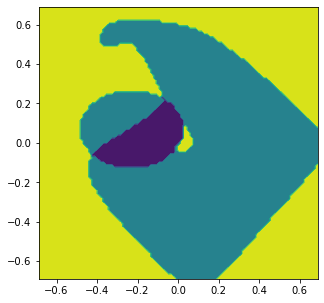

In [7]:
plt.figure(figsize=[5,5])
a = 0.26
b = 0.20
center = [-0.23, 0.07]
ellipse_mask = ~( ((H1-center[0])/a)**2 + ((H2-center[1])/b)**2 < 1 )
plt.contourf(H1, H2, H1dot.mask.astype(int)+ellipse_mask.astype(int))
plt.show()
ploblematic_zone = np.logical_or(H1dot.mask, ellipse_mask)

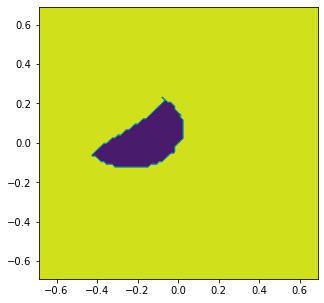

In [8]:
plt.figure(figsize=[5,5])
plt.contourf(H1, H2, ploblematic_zone)
plt.show()

In [12]:
H1dot_prob = H1dot.copy()
H1dot_prob.mask = ploblematic_zone

H2dot_prob = H2dot.copy()
H2dot_prob.mask = ploblematic_zone

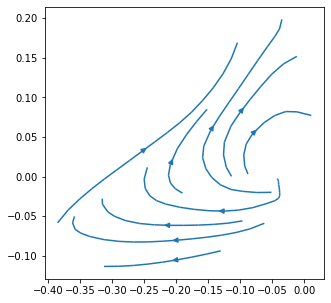

In [13]:
plt.figure(figsize=[5,5])
plt.streamplot(H1, H2, H1dot_prob, H2dot_prob, density=2)
plt.show()

In [91]:
func = GaussianFunc_ChevMetric_New(2, 32, 2, 32, 2)
# func.apply(init_weights)
lr = 0.01
N_grad = N.detach().requires_grad_(True)
params = list(func.parameters())
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
pred_steps = 500
OldParams = None
min_loss = np.inf

In [92]:
try:
    for itr in range(1, 10**6):
        optimizer.zero_grad()
        pred = func(N_grad)
        loss = ((pred - V_norm)**2).sum()/pred.shape[0]
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))
    
        if loss_meter.avg < min_loss:
          torch.save(func, 'min_func_Fly.pt')
          min_loss = loss_meter.avg
          print("min model_updated")

except KeyboardInterrupt:

    print('Training complete after {} iters.'.format(itr))

Iter: 201809, MSE loss: -0.0044
Training complete after 201810 iters.


In [99]:
min_func = torch.load('min_func_Fly.pt')

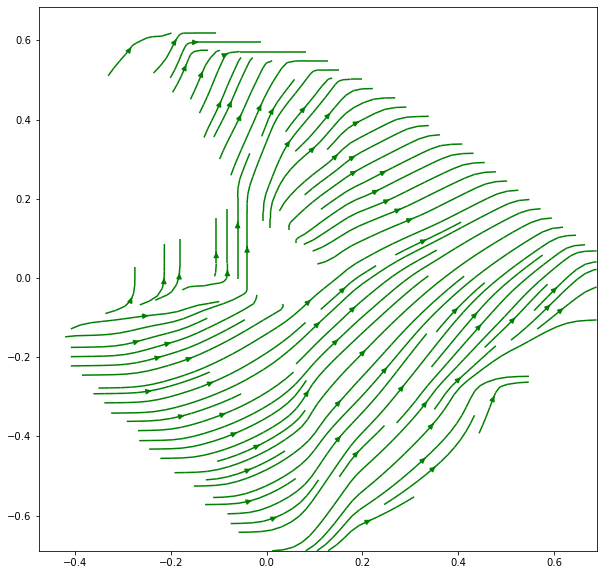

In [373]:
H1a, H2a = get_data_func_Fly(min_func.metric_nn, size = 100, ma = H1dot.mask)
plt.figure(figsize=[10,10])
plt.streamplot(H1, H2, H1a, H2a, density=2, color = 'g')
plt.show()

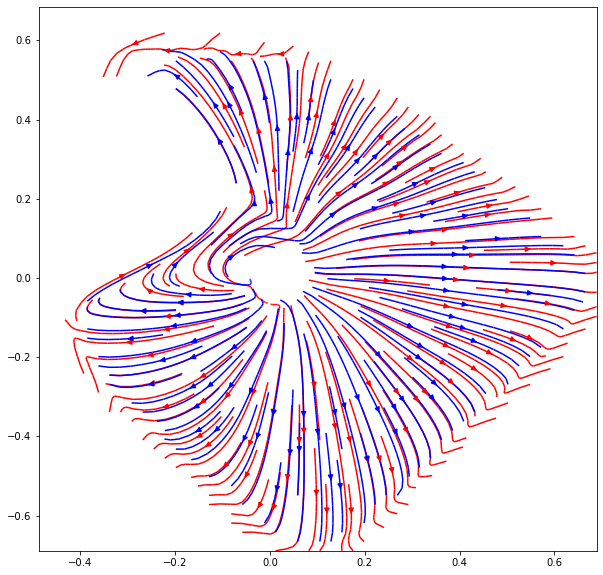

In [100]:
H1a, H2a = get_data_func_Fly(min_func, size = 100, ma = H1dot.mask)
plt.figure(figsize=[10,10])
plt.streamplot(H1, H2, H1a, H2a, density=2, color = 'r')
plt.streamplot(H1, H2, H1dot, H2dot, density=2, color = 'b')
plt.show()

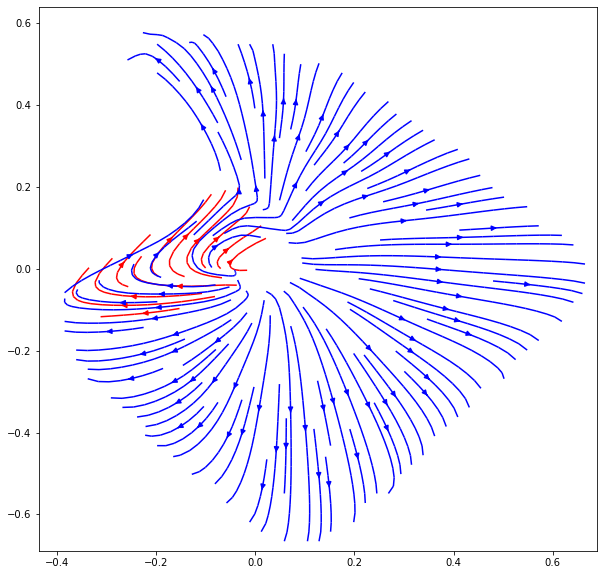

In [188]:
H1a, H2a = get_data_func_Fly(func_ChevMetric, size = 100, ma = H1dot_prob.mask)
plt.figure(figsize=[10,10])
plt.streamplot(H1, H2, H1a, H2a, density=2, color = 'r')
plt.streamplot(H1, H2, H1dot, H2dot, density=2, color = 'b')
plt.show()

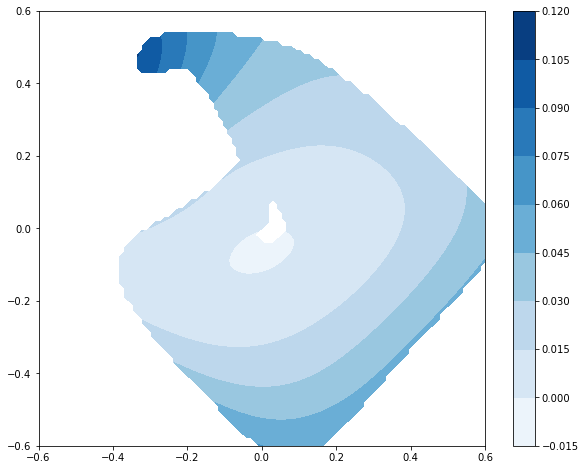

In [103]:
X = np.linspace(- 0.6, 0.6, 100)
h_mask = get_data_V_Fly(min_func, ma = H1dot.mask, num = None, flip = False, X = X)

x, y = np.meshgrid(X, X)
plt.figure(figsize = [10, 8])
plt.contourf(x, y, h_mask, cmap='Blues', )
plt.colorbar()
plt.show()

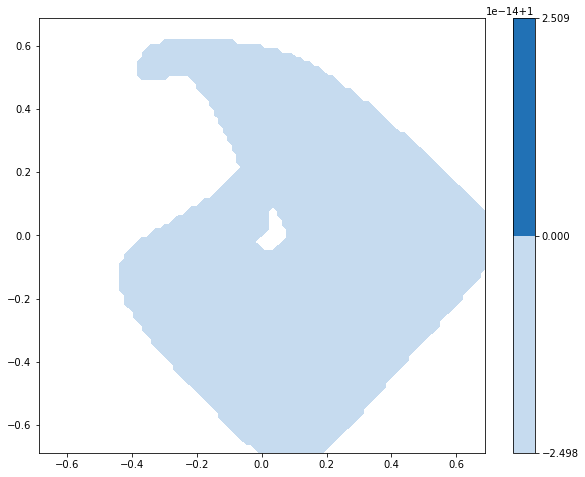

In [24]:
size = len(H1)
a = func.switch(torch.Tensor(np.stack([H1, H2], -1).reshape(size*size, 2)))
a = a.cpu().detach().numpy()
h = a.reshape(size,size)
h_mask = np.ma.masked_array(h, mask=H1dot.mask)

plt.figure(figsize = [10, 8])
plt.contourf(H1, H2, h_mask, cmap='Blues')
plt.colorbar()
plt.show()

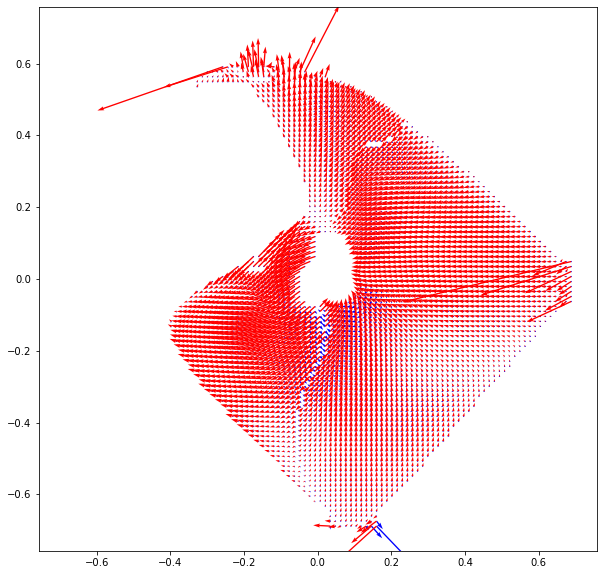

In [113]:
coord, eigvec1, eigvec2 = get_data_eig_Fly(min_func , erode_size = 6, eig_type = 'vector', ma = H1dot.mask)
sc = 10**-3
x, y = coord
u1, v1 = eigvec1
u2, v2 = eigvec2
plt.figure(figsize=[10,10])
plt.quiver(x,y,u1,v1, color= 'b',angles='xy', scale_units='xy', scale=1/sc)
plt.quiver(x,y,u2,v2, color='r',angles='xy', scale_units='xy', scale=1/sc)
plt.show()

In [198]:
size = len(H1)
h = func_ChevMetric.metric(torch.Tensor(np.stack([H1, H2], -1).reshape(size * size, 2))).cpu().detach()
h = h.reshape(size, size, 4)
ind_prob = np.argwhere(~ploblematic_zone)

-0.20175551506501016 0.04869960708465759 tensor([37.0647, 47.3851, 47.3851, 61.0965])


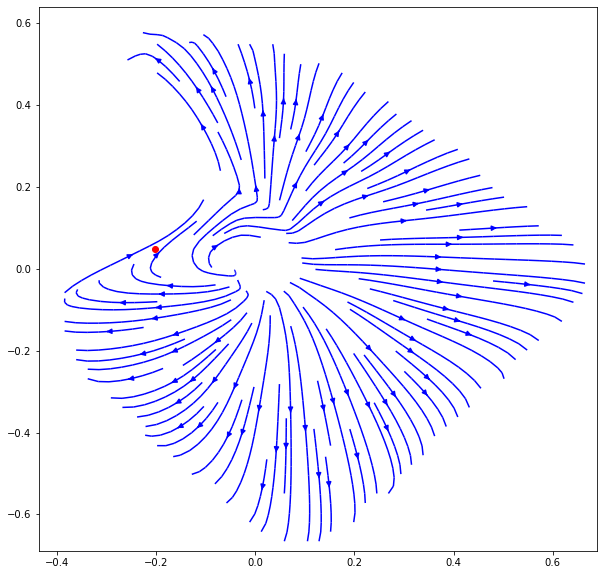

In [246]:
x, y = ind_prob[300]
print( H1[x, y], H2[x, y], h[x, y, :])
plt.figure(figsize=[10,10])
plt.streamplot(H1, H2, H1dot, H2dot, density=2, color = 'b')
plt.plot(H1[x, y], H2[x, y], 'o', color='r')
plt.show()

In [300]:
angle = []
for i in range(len(ind_prob)):
    x, y = ind_prob[i]
    Matrix = h[x, y, :].reshape(2, 2)
    eigval, eigvec = torch.symeig(Matrix, eigenvectors=True)
    ang_temp = torch.atan(eigvec[0, 1]/eigvec[0, 0]).detach().numpy()
    angle.append(ang_temp)

angle = np.stack(angle, axis=0)

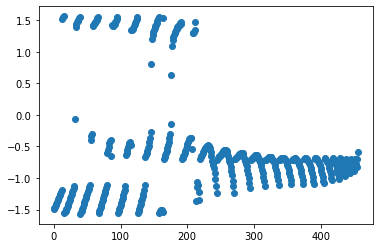

In [302]:
plt.figure()
plt.plot(angle, 'o')
plt.show()

In [343]:
temp_dim = func.metric_nn(N_grad).shape
A = func.metric_nn(N_grad).reshape(temp_dim[:-1]+(2, 2)) 
B = func.total_grad(N_grad)
torch.matmul(B, A).shape

torch.Size([4225, 4225, 2])

In [72]:
pred = func(N_grad)

In [80]:
C.shape

torch.Size([100, 2, 2])

In [42]:
A = torch.ones(100, 2, 2).float()
B = torch.zeros(100, 2).float()

In [63]:
B_2 = B.unsqueeze(2)
A_t = A.transpose(1, 2)

In [55]:
B_2.shape

torch.Size([100, 2, 1])

In [85]:
C = torch.matmul(A, B_2)

In [86]:
C = C.squeeze()
C.shape

torch.Size([100, 2])